# Polynomial regression

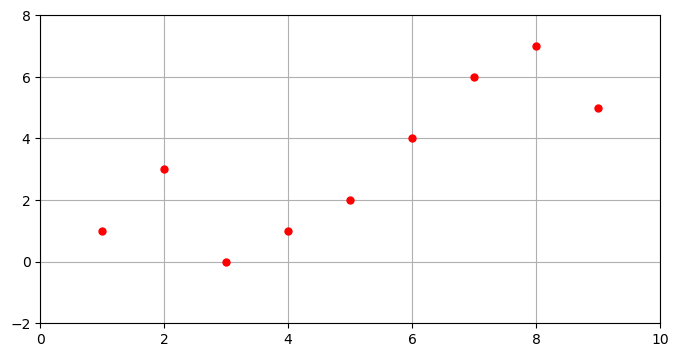

In [1]:
# define (x,y) coordinates of the points
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9 ]
y = [ 1, 3, 0, 1, 2, 4, 6, 7, 5 ]

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
axis([0,10,-2,8])
grid("on")

In [3]:
# order of polynomial to use
k = 3

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

In [10]:
using Pkg
Pkg.add("SCS")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed SCS ─ v0.5.1
  Updating `~/.julia/environments/v1.1/Project.toml`
  [c946c3f1] + SCS v0.5.1
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [c946c3f1] + SCS v0.5.1
  Building SCS → `~/.julia/packages/SCS/L1XbN/deps/build.log`


In [28]:
# NOTE: must have either Gurobi or Mosek installed!

using JuMP, Ipopt
#using JuMP, ECOS
#using JuMP, SCS
m = Model(with_optimizer(Ipopt.Optimizer))
#m = Model(solver=MosekSolver(LOG=0))
#m = Model(solver=GurobiSolver(OutputFlag=0))
#m = Model(solver=GurobiSolver(OutputFlag=1,NumericFocus=2))    # extra option to do extra numerical conditioning
#m = Model(solver=GurobiSolver(OutputFlag=1,BarHomogeneous=1))  # extra option to use alternative algorithms

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )

print(m)
JuMP.optimize!(m)

obj_value=JuMP.objective_value(m)
println("Valor func objetivo=", obj_value)

uopt=zeros(4,1)
for i in 1:4
    println(" u[$(i)] = $(JuMP.value(u[i]))")
    uopt[i]=JuMP.value(u[i])
end
println("")


Min 978405 u[1]² + 241650 u[2]*u[1] + 30666 u[3]*u[1] + 4050 u[4]*u[1] + 15333 u[2]² + 4050 u[3]*u[2] + 570 u[4]*u[2] + 285 u[3]² + 90 u[4]*u[3] + 9 u[4]² - 20980 u[1] - 2740 u[2] - 376 u[3] - 58 u[4] + 141
Subject to
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:       

In [29]:
uopt

4×1 Array{Float64,2}:
 -0.06481481481485069
  1.042568542569101  
 -4.083092833095312  
  5.206349206351991  

In [18]:
inv(A'*A)*(A'*y)

4-element Array{Float64,1}:
 -0.06481481481481666
  1.0425685425686027 
 -4.083092833093133  
  5.206349206349614  

In [19]:
A\y

4-element Array{Float64,1}:
 -0.06481481481481498
  1.0425685425685456 
 -4.083092833092849  
  5.206349206349226  

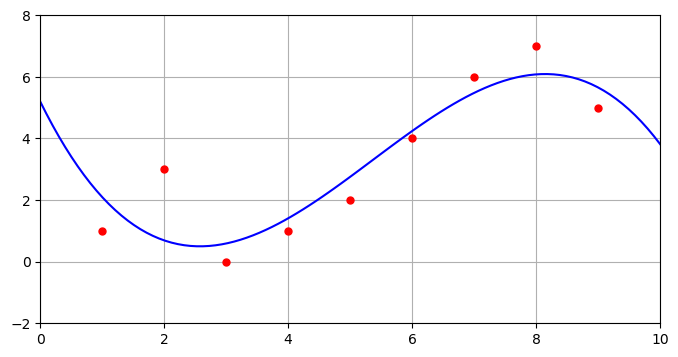

In [30]:
using PyPlot
npts = 100
xfine = LinRange(0,10,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
axis([0,10,-2,8])
grid()

In [36]:
# NOTE: problem can be solved using ECOS or SCS if written as an "SOCP" --- more on this later!
# Here is a working example:

using JuMP, ECOS, SCS, LinearAlgebra

m = Model(with_optimizer(SCS.Optimizer))

@variable(m, u[1:k+1])
@variable(m, t)
#@constraint(m, norm(y - A*u) <= t)
@constraint(m, [t; y - A*u] in SecondOrderCone())
@objective(m, Min, t)

print(m)
JuMP.optimize!(m)

obj_value=JuMP.objective_value(m)
println("Valor func objetivo=", obj_value)

uopt=zeros(4,1)
for i in 1:4
    println(" u[$(i)] = $(JuMP.value(u[i]))")
    uopt[i]=JuMP.value(u[i])
end
println("")

Min t
Subject to
 [t, -u[1] - u[2] - u[3] - u[4] + 1, -8 u[1] - 4 u[2] - 2 u[3] - u[4] + 3, -27 u[1] - 9 u[2] - 3 u[3] - u[4], -64 u[1] - 16 u[2] - 4 u[3] - u[4] + 1, -125 u[1] - 25 u[2] - 5 u[3] - u[4] + 2, -216 u[1] - 36 u[2] - 6 u[3] - u[4] + 4, -343 u[1] - 49 u[2] - 7 u[3] - u[4] + 6, -512 u[1] - 64 u[2] - 8 u[3] - u[4] + 7, -729 u[1] - 81 u[2] - 9 u[3] - u[4] + 5] ∈ MathOptInterface.SecondOrderCone(10)
Valor func objetivo=3.037405102302786
 u[1] = -0.06481481562187193
 u[2] = 1.0425685520816543
 u[3] = -4.083092859468906
 u[4] = 5.206349203734757

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 37, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables